In [8]:
%matplotlib widget
import os
os.environ["GDAL_DATA"] = "/Users/parndt/anaconda3/envs/eeicelakes-env/share/gdal"
os.environ["PROJ_LIB"] = "/Users/parndt/anaconda3/envs/eeicelakes-env/share/proj"
os.environ["PROJ_DATA"] = "/Users/parndt/anaconda3/envs/eeicelakes-env/share/proj"
import ee
import h5py
import math
import datetime
import requests
import traceback
import shapely
import pandas as pd
import numpy as np
import geopandas as gpd
from datetime import datetime 
from datetime import timedelta
from datetime import timezone
import rasterio as rio
from rasterio import plot as rioplot
from rasterio import warp
import matplotlib
import matplotlib.pylab as plt
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image, display

from lakeanalysis.utils import dictobj, convert_time_to_string, read_melt_lake_h5

In [9]:
#####################################################################
def get_sentinel2_cloud_collection(area_of_interest, date_time, days_buffer):

    datetime_requested = datetime.strptime(date_time, '%Y-%m-%dT%H:%M:%SZ')
    start_date = (datetime_requested - timedelta(days=days_buffer)).strftime('%Y-%m-%dT%H:%M:%SZ')
    end_date = (datetime_requested + timedelta(days=days_buffer)).strftime('%Y-%m-%dT%H:%M:%SZ')
    print('Looking for Sentinel-2 images from %s to %s' % (start_date, end_date), end=' ')

    # Import and filter S2 SR HARMONIZED
    s2_sr_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(area_of_interest)
        .filterDate(start_date, end_date))

    # Import and filter s2cloudless.
    s2_cloudless_collection = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(area_of_interest)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    cloud_collection = ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_collection,
        'secondary': s2_cloudless_collection,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

    cloud_collection = cloud_collection.map(lambda img: img.addBands(ee.Image(img.get('s2cloudless')).select('probability')))

    def set_is2_cloudiness(img, aoi=area_of_interest):
        cloudprob = img.select(['probability']).reduceRegion(reducer=ee.Reducer.mean(), 
                                                             geometry=aoi, 
                                                             bestEffort=True, 
                                                             maxPixels=1e6)
        return img.set('ground_track_cloud_prob', cloudprob.get('probability'))

    cloud_collection = cloud_collection.map(set_is2_cloudiness)

    return cloud_collection

    
#####################################################################
def download_imagery(fn, lk, gt, imagery_filename, days_buffer=5, max_cloud_prob=15, gamma_value=1.8, buffer_factor=1.2):

    lake_mean_delta_time = lk.mframe_data.dt.mean()
    ATLAS_SDP_epoch_datetime = datetime(2018, 1, 1, tzinfo=timezone.utc) # 2018-01-01:T00.00.00.000000 UTC, from ATL03 data dictionary 
    ATLAS_SDP_epoch_timestamp = datetime.timestamp(ATLAS_SDP_epoch_datetime)
    lake_mean_timestamp = ATLAS_SDP_epoch_timestamp + lake_mean_delta_time
    lake_mean_datetime = datetime.fromtimestamp(lake_mean_timestamp, tz=timezone.utc)
    time_format_out = '%Y-%m-%dT%H:%M:%SZ'
    is2time = datetime.strftime(lake_mean_datetime, time_format_out)

    # get the bounding box
    lon_rng = gt.lon.max() - gt.lon.min()
    lat_rng = gt.lat.max() - gt.lat.min()
    fac = 0.25
    bbox = [gt.lon.min()-fac*lon_rng, gt.lat.min()-fac*lat_rng, gt.lon.max()+fac*lon_rng, gt.lat.max()+fac*lat_rng]
    poly = [(bbox[x[0]], bbox[x[1]]) for x in [(0,1), (2,1), (2,3), (0,3), (0,1)]]
    roi = ee.Geometry.Polygon(poly)

    # get the earth engine collection
    collection_size = 0
    if days_buffer > 200:
        days_buffer = 200
    increment_days = days_buffer
    while (collection_size<5) & (days_buffer <= 200):
    
        collection = get_sentinel2_cloud_collection(area_of_interest=roi, date_time=is2time, days_buffer=days_buffer)
    
        # filter collection to only images that are (mostly) cloud-free along the ICESat-2 ground track
        cloudfree_collection = collection.filter(ee.Filter.lt('ground_track_cloud_prob', max_cloud_prob))
        
        collection_size = cloudfree_collection.size().getInfo()
        if collection_size == 1: 
            print('--> there is %i cloud-free image.' % collection_size)
        elif collection_size > 1: 
            print('--> there are %i cloud-free images.' % collection_size)
        else:
            print('--> there are not enough cloud-free images: widening date range...')
        days_buffer += increment_days
    
        # get the time difference between ICESat-2 and Sentinel-2 and sort by it 
        is2time = lk.date_time
        def set_time_difference(img, is2time=is2time):
            timediff = ee.Date(is2time).difference(img.get('system:time_start'), 'second').abs()
            return img.set('timediff', timediff)
        cloudfree_collection = cloudfree_collection.map(set_time_difference).sort('timediff')

    # create a region around the ground track over which to download data
    lon_center = gt.lon.mean()
    lat_center = gt.lat.mean()
    gt_length = gt.x10.max() - gt.x10.min()
    point_of_interest = ee.Geometry.Point(lon_center, lat_center)
    region_of_interest = point_of_interest.buffer(gt_length*0.5*buffer_factor)

    if collection_size > 0:
        # select the first image, and turn the colleciton into an 8-bit RGB for download
        selectedImage = cloudfree_collection.first()
        mosaic = cloudfree_collection.sort('timediff', False).mosaic()
        rgb = mosaic.select('B4', 'B3', 'B2')
        rgb = rgb.unitScale(0, 10000).clamp(0.0, 1.0)
        rgb_gamma = rgb.pow(1/gamma_value)
        rgb8bit= rgb_gamma.multiply(255).uint8()
        
        # from the selected image get some stats: product id, cloud probability and time difference from icesat-2
        prod_id = selectedImage.get('PRODUCT_ID').getInfo()
        cld_prb = selectedImage.get('ground_track_cloud_prob').getInfo()
        s2datetime = datetime.fromtimestamp(selectedImage.get('system:time_start').getInfo()/1e3)
        s2datestr = datetime.strftime(s2datetime, '%Y-%b-%d')
        is2datetime = datetime.strptime(lk.date_time, '%Y-%m-%dT%H:%M:%SZ')
        timediff = s2datetime - is2datetime
        days_diff = timediff.days
        if days_diff == 0: diff_str = 'Same day as'
        if days_diff == 1: diff_str = '1 day after'
        if days_diff == -1: diff_str = '1 day before'
        if days_diff > 1: diff_str = '%i days after' % np.abs(days_diff)
        if days_diff < -1: diff_str = '%i days before' % np.abs(days_diff)
        
        print('--> Closest cloud-free Sentinel-2 image:')
        print('    - product_id: %s' % prod_id)
        print('    - time difference: %s' % timediff)
        print('    - mean cloud probability: %.1f' % cld_prb)
        
        # get the download URL and download the selected image
        success = False
        scale = 10
        tries = 0
        while (success == False) & (tries <= 7):
            try:
                downloadURL = rgb8bit.getDownloadUrl({'name': 'mySatelliteImage',
                                                          'crs': selectedImage.select('B3').projection().crs(),
                                                          'scale': scale,
                                                          'region': region_of_interest,
                                                          'filePerBand': False,
                                                          'format': 'GEO_TIFF'})
        
                response = requests.get(downloadURL)
                with open(imagery_filename, 'wb') as f:
                    f.write(response.content)
        
                print('--> Downloaded the 8-bit RGB image as %s.' % imagery_filename)
                success = True
                tries += 1
            except:
                traceback.print_exc()
                scale *= 2
                print('-> download unsuccessful, increasing scale to %.1f...' % scale)
                success = False
                tries += 1


#####################################################################
def add_graticule(img, ax_img):
    from lakeanalysis.curve_intersect import intersection
    latlon_bbox = warp.transform(img.crs, {'init': 'epsg:4326'}, 
                                 [img.bounds[i] for i in [0,2,2,0,0]], 
                                 [img.bounds[i] for i in [1,1,3,3,1]])
    min_lat = np.min(latlon_bbox[1])
    max_lat = np.max(latlon_bbox[1])
    min_lon = np.min(latlon_bbox[0])
    max_lon = np.max(latlon_bbox[0])
    latdiff = max_lat-min_lat
    londiff = max_lon-min_lon
    diffs = np.array([0.0001, 0.0002, 0.00025, 0.0004, 0.0005,
                      0.001, 0.002, 0.0025, 0.004, 0.005, 
                      0.01, 0.02, 0.025, 0.04, 0.05, 0.1, 0.2, 0.25, 0.4, 0.5, 1, 2])
    latstep = np.min(diffs[diffs>latdiff/8])
    lonstep = np.min(diffs[diffs>londiff/8])
    minlat = np.floor(min_lat/latstep)*latstep
    maxlat = np.ceil(max_lat/latstep)*latstep
    minlon = np.floor(min_lon/lonstep)*lonstep
    maxlon = np.ceil(max_lon/lonstep)*lonstep

    # plot meridians and parallels
    # xl = (img.bounds.left, img.bounds.right)
    # yl = (img.bounds.bottom, img.bounds.top)
    xl = ax_img.get_xlim()
    yl = ax_img.get_ylim()
    meridians = np.arange(minlon,maxlon, step=lonstep)
    parallels = np.arange(minlat,maxlat, step=latstep)
    latseq = np.linspace(minlat,maxlat,200)
    lonseq = np.linspace(minlon,maxlon,200)
    gridcol = 'k'
    gridls = ':'
    gridlw = 0.5
    topline = [[xl[0],xl[1]],[yl[1],yl[1]]]
    bottomline = [[xl[0],xl[1]],[yl[0],yl[0]]]
    leftline = [[xl[0],xl[0]],[yl[0],yl[1]]]
    rightline = [[xl[1],xl[1]],[yl[0],yl[1]]]
    for me in meridians:
        gr_trans = warp.transform({'init': 'epsg:4326'},img.crs,me*np.ones_like(latseq),latseq)
        deglab = ' %.10g°E' % me if me >= 0 else ' %.10g°W' % -me
        intx,inty = intersection(bottomline[0], bottomline[1], gr_trans[0], gr_trans[1])
        rot = np.arctan2(gr_trans[1][-1] - gr_trans[1][0], gr_trans[0][-1] - gr_trans[0][0]) * 180 / np.pi
        if len(intx) > 0:
            intx = intx[0]
            inty = inty[0]
            ax_img.text(intx, inty, deglab, fontsize=6, color='gray',verticalalignment='top',horizontalalignment='center',
                    rotation=rot)
        thislw = gridlw
        ax_img.plot(gr_trans[0],gr_trans[1],c=gridcol,ls=gridls,lw=thislw,alpha=0.5)
    for pa in parallels:
        gr_trans = warp.transform({'init': 'epsg:4326'},img.crs,lonseq,pa*np.ones_like(lonseq))
        thislw = gridlw
        deglab = ' %.10g°N' % pa if pa >= 0 else ' %.10g°S' % -pa
        intx,inty = intersection(rightline[0], rightline[1], gr_trans[0], gr_trans[1])
        rot = np.arctan2(gr_trans[1][-1] - gr_trans[1][0], gr_trans[0][-1] - gr_trans[0][0]) * 180 / np.pi
        if len(intx) > 0:
            intx = intx[0]
            inty = inty[0]
            ax_img.text(intx, inty, deglab, fontsize=6, color='gray',verticalalignment='center',horizontalalignment='left',
                       rotation=rot)
        ax_img.plot(gr_trans[0],gr_trans[1],c=gridcol,ls=gridls,lw=thislw,alpha=0.5)
        ax_img.set_xlim(xl)
        ax_img.set_ylim(yl)
        

#####################################################################
def plot_imagery(fn, days_buffer=5, max_cloud_prob=15, xlm=[None, None], ylm=[None, None], gamma_value=1.8, imagery_filename=None,
                 re_download=True, ax=None, buffer_factor=1.3):
                     
    lk = dictobj(read_melt_lake_h5(fn))
    df = lk.photon_data.copy()
    if not xlm[0]:
        xlm[0] = df.xatc.min()
    if not xlm[1]:
        xlm[1] = df.xatc.max()
    if not ylm[0]:
        ylm[0] = lk.surface_elevation-2*lk.max_depth
    if not ylm[1]:
        ylm[1] = lk.surface_elevation+lk.max_depth
    if not imagery_filename:
        imagery_filename = 'imagery' + fn[fn.rfind('/'):].replace('.h5','.tif')
    
    
    df = df[(df.xatc >= xlm[0]) & (df.xatc <= xlm[1]) & (df.h >= ylm[0]) & (df.h <= ylm[1])].reset_index(drop=True).copy()
    x_off = np.min(df.xatc)
    df.xatc -= x_off
    
    dfd = lk.depth_data.copy()
    dfd.xatc -= x_off

    # get the ground track
    df['x10'] = np.round(df.xatc, -1)
    gt = df.groupby(by='x10')[['lat', 'lon']].median().reset_index()
    lon_center = gt.lon.mean()
    lat_center = gt.lat.mean()
    
    if ((not os.path.isfile(imagery_filename)) or re_download) and ('modis' not in imagery_filename):
        download_imagery(fn=fn, lk=lk, gt=gt, imagery_filename=imagery_filename, days_buffer=days_buffer, 
                         max_cloud_prob=max_cloud_prob, gamma_value=gamma_value, buffer_factor=buffer_factor)
    
    try:
        myImage = rio.open(imagery_filename)
        
        # make the figure
        if not ax:
            fig, ax = plt.subplots(figsize=[6,6])
        
        rioplot.show(myImage, ax=ax)
        ax.axis('off')
    
        ximg, yimg = warp.transform(src_crs='epsg:4326', dst_crs=myImage.crs, xs=np.array(gt.lon), ys=np.array(gt.lat))
        if 'modis' in imagery_filename:
            xrng = ximg[-1] - ximg[0]
            yrng = yimg[-1] - yimg[0]
            fac = 30
            print('using saved modis image')
            ax.plot([ximg[-1]+fac*xrng,ximg[0]-fac*xrng], [yimg[-1]+fac*yrng, yimg[0]-fac*yrng], 'k:', lw=1)
            ax.annotate('', xy=(ximg[-1]+fac*xrng, yimg[-1]+fac*yrng), xytext=(ximg[0]-fac*xrng, yimg[0]-fac*yrng),
                             arrowprops=dict(width=0, lw=0, headwidth=5, headlength=5, color='k'),zorder=1000)

        else:
            print('plotting ground track')
            
            # ax.annotate('', xy=(ximg[-1], yimg[-1]), xytext=(ximg[0], yimg[0]),
            #                  arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='k'),zorder=1000)
            arrow_gt = ax.arrow(ximg[0], yimg[0], ximg[-1]-ximg[0], yimg[-1]-yimg[0], label='ICESat-2 ground track', 
                             width=20, head_width=70, head_length=100, color='k')

            isdepth = dfd.depth>0
            bed = dfd.h_fit_bed
            bed[~isdepth] = np.nan
            bed[(dfd.depth>2) & (dfd.conf < 0.3)] = np.nan
            surf = np.ones_like(dfd.xatc) * lk.surface_elevation
            surf[~isdepth] = np.nan
            xatc_surf = np.array(dfd.xatc)[~np.isnan(surf)]
            lon_bed = np.array(dfd.lon)
            lat_bed = np.array(dfd.lat)
            lon_bed[(np.isnan(surf)) & (np.isnan(bed))] = np.nan
            lat_bed[(np.isnan(surf)) & (np.isnan(bed))] = np.nan
            xb, yb = warp.transform(src_crs='epsg:4326', dst_crs=myImage.crs, xs=lon_bed, ys=lat_bed)
            line_extent, = ax.plot(xb, yb, color='r', lw=1, zorder=5000, solid_capstyle='butt', label='along-track lake extent')

            def make_legend_arrow(legend, orig_handle, xdescent, ydescent, width, height, fontsize):
                return mpatches.FancyArrow(0, 0.5*height, width, 0, length_includes_head=True, head_width=0.5*height)
            ax.legend(handles=[arrow_gt, line_extent], loc='upper left', fontsize=9,
                       handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow)})
        
        if not ax:
            fig.tight_layout(pad=0)
    
        return myImage, lon_center, lat_center
    except: 
        return None, lon_center, lat_center
        traceback.print_exc()

                     
#####################################################################
def plotIS2(fn, ax=None, xlm=[None, None], ylm=[None,None], cmap=cmc.lapaz_r, name='ICESat-2 data'):
    lk = dictobj(read_melt_lake_h5(fn))
    df = lk.photon_data.copy()
    dfd = lk.depth_data.copy()
    if not xlm[0]:
        xlm[0] = df.lat.min()
    if not xlm[1]:
        xlm[1] = df.lat.max()
    if not ylm[0]:
        ylm[0] = lk.surface_elevation-2*lk.max_depth
    if not ylm[1]:
        ylm[1] = lk.surface_elevation+1.0*lk.max_depth
    df = df[(df.lat >= xlm[0]) & (df.lat <= xlm[1]) & (df.h >= ylm[0]) & (df.h <= ylm[1])].reset_index(drop=True).copy()
    dfd = dfd[(dfd.lat >= xlm[0]) & (dfd.lat <= xlm[1]) & (dfd.h_fit_bed >= ylm[0])].reset_index(drop=True).copy()
    x_off = np.min(df.xatc)
    df.xatc -= x_off
    dfd.xatc -= x_off
    
    isdepth = dfd.depth>0
    bed = dfd.h_fit_bed
    bed[~isdepth] = np.nan
    bed[(dfd.depth>2) & (dfd.conf < 0.3)] = np.nan
    surf = np.ones_like(dfd.xatc) * lk.surface_elevation
    surf[~isdepth] = np.nan
    surf_only = surf[~np.isnan(surf)]
    bed_only = bed[(~np.isnan(surf)) & (~np.isnan(bed))]
    xatc_surf = np.array(dfd.xatc)[~np.isnan(surf)]
    xatc_bed = np.array(dfd.xatc)[(~np.isnan(surf)) & (~np.isnan(bed))]
    lat_surf = np.array(dfd.lat)[~np.isnan(surf)]
    lat_bed = np.array(dfd.lat)[(~np.isnan(surf)) & (~np.isnan(bed))]
    
    # make the figure
    if not ax:
        fig, ax = plt.subplots(figsize=[8,5])

    df['is_afterpulse']= df.prob_afterpulse > np.random.uniform(0,1,len(df))
    if not cmap:
        # ax.scatter(df.xatc, df.h, s=1, c='k')
        hdl_phot = ax.scatter(df.lat[~df.is_afterpulse], df.h[~df.is_afterpulse], s=1, c='k', label='ATL03 photons')
    else:
        ax.scatter(df.lat[~df.is_afterpulse], df.h[~df.is_afterpulse], s=1, c=df.snr, cmap=cmap)
        
    # ax.scatter(dfd.xatc[isdepth], dfd.h_fit_bed[isdepth], s=4, color='r', alpha=dfd.conf[isdepth])
    # ax.plot(dfd.xatc, dfd.h_fit_bed, color='gray', lw=0.5)
    
    hdl_bed, = ax.plot(dfd.lat, bed, color='r', lw=1, label='lakebed')
    hdl_surf, = ax.plot(dfd.lat, surf, color='C0', lw=1, label='open water surface')

    # df['x10'] = np.round(df.xatc, -1)
    # gt = df.groupby(by='x10')[['lat', 'lon']].median().sort_values(by='x10').reset_index()
    
    # # add latitude
    # lx = gt.sort_values(by='x10').iloc[[0,-1]][['x10','lat']].reset_index(drop=True)
    # _lat = np.array(lx.lat)
    # _xatc = np.array(lx.x10)
    # def lat2xatc(l):
    #     return _xatc[0] + (l - _lat[0]) * (_xatc[1] - _xatc[0]) /(_lat[1] - _lat[0])
    # def xatc2lat(x):
    #     return _lat[0] + (x - _xatc[0]) * (_lat[1] - _lat[0]) / (_xatc[1] - _xatc[0])
    # secax = ax.secondary_xaxis(-0.07, functions=(xatc2lat, lat2xatc))
    # secax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    # secax.set_xlabel('along-track distance / latitude',labelpad=0)
    # secax.tick_params(axis='both', which='major')
    # secax.ticklabel_format(useOffset=False, style='plain')

    # add the length of surface
    arr_y = lk.surface_elevation+lk.max_depth*0.25
    x_start = np.min(xatc_surf)
    x_end = np.max(xatc_surf)
    x_mid = (x_end + x_start) / 2
    len_surf_m = np.floor((x_end-x_start)/100)*100
    len_surf_km = len_surf_m/1000
    lat_start = np.min(lat_surf)
    lat_end = np.min(lat_surf)
    lat_mid = (lat_end + lat_start) / 2
    arr_x1 = x_mid - len_surf_m / 2
    arr_x2 = x_mid + len_surf_m / 2
    ax.annotate('', xy=(lat_start, arr_y), xytext=(lat_end, arr_y),
                         arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='C0'),zorder=1000)
    ax.annotate('', xy=(lat_end, arr_y), xytext=(lat_start, arr_y),
                         arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='C0'),zorder=1000)
    ax.text(lat_mid, arr_y, r'\textbf{%.1f km}' % len_surf_km, fontsize=12, ha='center', va='bottom', color='C0', fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2,rounding_size=0.5', lw=0))

    # add the max depth
    y_low = np.min(bed_only)
    y_up = lk.surface_elevation
    arr_x = lat_bed[np.argmin(bed_only)]
    # arr_x = xlm[0] - 0.0* (xlm[1] - xlm[0])
    y_len = y_up - y_low
    y_mid = (y_up + y_low) / 2
    arr_len = y_len
    arr_y1 = y_mid + arr_len / 2.1
    arr_y2 = y_mid - arr_len / 2.1
    ref_index = 1.33
    dep_round = np.round(y_len / ref_index, 1)
    ax.annotate('', xy=(arr_x, arr_y2), xytext=(arr_x, arr_y1),
                         arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='r'),zorder=1000)
    ax.annotate('', xy=(arr_x, arr_y1), xytext=(arr_x, arr_y2),
                         arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='r'),zorder=1000)
    ax.text(arr_x, y_mid, r'\textbf{%.1f m}' % dep_round, fontsize=12, ha='right', va='center', color='r', fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.8, lw=0, boxstyle='round,pad=0.2,rounding_size=0.5'), rotation=90)

    # add the title
    datestr = datetime.strftime(datetime.strptime(lk.date_time[:10],'%Y-%m-%d'), '%d %B %Y')
    sheet = lk.ice_sheet
    region = lk.polygon_filename.split('_')[-1].replace('.geojson', '')
    if sheet == 'AIS':
        region = region + ' (%s)' % lk.polygon_filename.split('_')[-2]
    latstr = lk.lat_str[:-1] + '°' + lk.lat_str[-1]
    lonstr = lk.lon_str[:-1] + '°' + lk.lon_str[-1]
    description = '%s\n%s - %s\n(%s, %s)' % (datestr, sheet, region, latstr, lonstr)

    # ax.text(0.5, 0.87, description, fontsize=12, ha='center', va='top', transform=ax.transAxes,
    #        bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.2,rounding_size=0.5', lw=0), zorder=3000)
    # ax.text(0.5, 0.9, '%s' % name, fontsize=18, ha='center', va='bottom', transform=ax.transAxes,
    #        bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.2,rounding_size=0.5', lw=0), fontweight='bold')

    ax.legend(handles=[hdl_phot, hdl_surf, hdl_bed], fontsize=10, loc='lower left', scatterpoints=4, framealpha=0.95)

    ax.set_xlim(xlm)
    ax.set_ylim(ylm)
    # ax.axis('off')

    # set axis labels for this particular lake
    xticks = ax.get_xticks()
    # xticks = [77.525, 77.52, 77.515, 77.51, 77.505]
    xticklabs = [r'$%g$\textdegree N' % xt if xt>=0 else r'$%g$\textdegree S' % xt for xt in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabs)

    # xticks = [   0.,  500., 1000., 1500., 2000., 2500.]
    # xticklabs = [r'$%g$ km' % (xt/1000) for xt in xticks]
    # ax.set_xticks(xticks)
    # ax.set_xticklabels(xticklabs)

    h0 = lk.surface_elevation
    refract_idx = 1.333
    def h2d(h):
        return (h0 - h) / refract_idx
    def d2h(d):
        return h0 - d * refract_idx 
    dax = ax.secondary_yaxis(location='right', functions=(h2d, d2h))
    dax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    dax.set_ylabel(r'water depth (m) \quad\quad', rotation=-90, color='r', labelpad=8)
    
    max_depth = 12
    ylm = ax.get_ylim()
    xlm = ax.get_xlim()
    ax.plot([xlm[1]]*2, [h0, d2h(max_depth)], 'r-', zorder=1000)
    
    yticks = np.arange(0, max_depth+0.01, 2)
    dax.set_yticks(yticks)
    
    dax.tick_params(axis='y', colors='red')

    ax.set_ylabel('elevation above geoid (m)')
    
#####################################################################
def plot_IS2_imagery(fn, axes=None, xlm=[None,None], ylm=[None,None], cmap=None, days_buffer=5, max_cloud_prob=15, 
                     gamma_value=1.8, imagery_filename=None, re_download=True, img_aspect=3/2, name='ICESat-2 data',
                     return_fig=False):

    if not axes:
        fig = plt.figure(figsize=[12,6], dpi=80)
        gs = fig.add_gridspec(1,3)
        axp = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1:])]
    else:
        axp = axes
        
    ax = axp[1]
    plotIS2(fn=fn, ax=ax, xlm=xlm, ylm=ylm, cmap=cmap, name=name)
    
    ax = axp[0]
    img, center_lon, center_lat = plot_imagery(fn=fn, days_buffer=days_buffer, max_cloud_prob=max_cloud_prob, xlm=xlm, ylm=ylm, 
        gamma_value=gamma_value, imagery_filename=imagery_filename, re_download=re_download, ax=ax)
            
    if (img_aspect > 1): 
        h_rng = img.bounds.top - img.bounds.bottom
        cntr = (img.bounds.right + img.bounds.left) / 2
        ax.set_xlim(cntr-0.5*h_rng/img_aspect, cntr+0.5*h_rng/img_aspect)
    elif img_aspect < 1: 
        w_rng = img.bounds.right - img.bounds.left
        cntr = (img.bounds.top + img.bounds.bottom) / 2
        ax.set_ylim(cntr-0.5*w_rng*img_aspect, cntr+0.5*w_rng/img_aspect)
            
    add_graticule(img, ax)
    
    if not axes:
        fig.tight_layout(pad=1, h_pad=0, w_pad=0)
        if not name:
            name = 'zzz' + lk.polygon_filename.split('_')[-1].replace('.geojson', '')
        outname = 'figplots/' + name.replace(' ', '') + fn[fn.rfind('/')+1:].replace('.h5','.jpg')
        fig.savefig(outname, dpi=300)

    if return_fig:
        plt.close(fig)
        return center_lon, center_lat, fig
    else:
        return center_lon, center_lat


Looking for Sentinel-2 images from 2021-07-15T05:32:05Z to 2021-07-25T05:32:05Z 

EEException: Invalid JSON payload received. Unexpected token.
 {"constantValue": [NaN, NaN]}, "3": {"f
                    ^

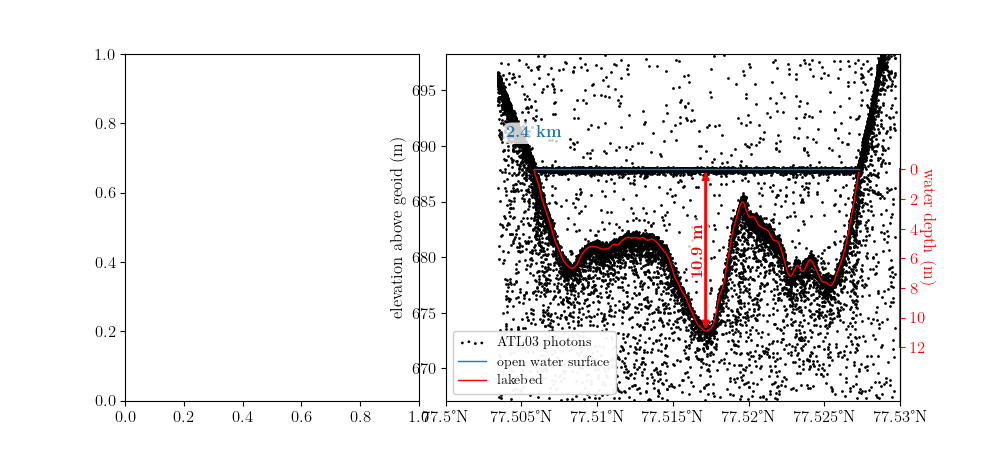

In [10]:
plt.close('all')

plt.rcParams.update({
    'font.size': 12,
    'text.usetex': True,
    'font.family': 'Optima'
})

highest_quality = {
    'name': '',
    'fn': 'data/lake_example/lake_02254624_GrIS_2021_simplified_GRE_2000_NE_ATL03_20210720053125_04061205_006_01_gt3r_0042.h5',
    'gamma_value': 1.0,
    'xlm': [None, None],
    'ylm': [None, None],
}

settings = {
    're_download': True,
    'img_aspect': 1.2,
    'days_buffer': 5,
}

fig = plt.figure(figsize=[10,4.5])
gs = fig.add_gridspec(ncols=5, nrows=1)

axs = []
axs.append(fig.add_subplot(gs[0, :2])) 
axs.append(fig.add_subplot(gs[0, 2:]))

toplot = highest_quality
lk = dictobj(read_melt_lake_h5(highest_quality['fn']))
plot_IS2_imagery(**highest_quality, **settings, axes=axs)
fig.tight_layout(pad=0.3, h_pad=0.3, w_pad=0.4)

# axs[0].set_xlim((432105.13949382154, 435435.8333333333))
# axs[0].set_ylim((8604139.440177007, 8607756.326779135))

In [ ]:
xx = [0, 1]
yy = [0, 2]
np.arctan((yy[1] - yy[0]) / (xx[1] - xx[0]))
np.arctan2(yy[1] - yy[0], xx[1] - xx[0]) * 180 / np.pi

In [ ]:
#####################################################################
def add_graticule(img, ax_img):
    from lakeanalysis.curve_intersect import intersection
    latlon_bbox = warp.transform(img.crs, {'init': 'epsg:4326'}, 
                                 [img.bounds[i] for i in [0,2,2,0,0]], 
                                 [img.bounds[i] for i in [1,1,3,3,1]])
    min_lat = np.min(latlon_bbox[1])
    max_lat = np.max(latlon_bbox[1])
    min_lon = np.min(latlon_bbox[0])
    max_lon = np.max(latlon_bbox[0])
    latdiff = max_lat-min_lat
    londiff = max_lon-min_lon
    diffs = np.array([0.0001, 0.0002, 0.00025, 0.0004, 0.0005,
                      0.001, 0.002, 0.0025, 0.004, 0.005, 
                      0.01, 0.02, 0.025, 0.04, 0.05, 0.1, 0.2, 0.25, 0.4, 0.5, 1, 2])
    latstep = np.min(diffs[diffs>latdiff/8])
    lonstep = np.min(diffs[diffs>londiff/8])
    minlat = np.floor(min_lat/latstep)*latstep
    maxlat = np.ceil(max_lat/latstep)*latstep
    minlon = np.floor(min_lon/lonstep)*lonstep
    maxlon = np.ceil(max_lon/lonstep)*lonstep

    # plot meridians and parallels
    xl = (img.bounds.left, img.bounds.right)
    yl = (img.bounds.bottom, img.bounds.top)
    meridians = np.arange(minlon,maxlon, step=lonstep)
    parallels = np.arange(minlat,maxlat, step=latstep)
    latseq = np.linspace(minlat,maxlat,200)
    lonseq = np.linspace(minlon,maxlon,200)
    gridcol = 'k'
    gridls = ':'
    gridlw = 0.5
    topline = [[xl[0],xl[1]],[yl[1],yl[1]]]
    bottomline = [[xl[0],xl[1]],[yl[0],yl[0]]]
    leftline = [[xl[0],xl[0]],[yl[0],yl[1]]]
    rightline = [[xl[1],xl[1]],[yl[0],yl[1]]]
    for me in meridians:
        gr_trans = warp.transform({'init': 'epsg:4326'},img.crs,me*np.ones_like(latseq),latseq)
        deglab = ' %.10g°E' % me if me >= 0 else ' %.10g°W' % -me
        intx,inty = intersection(topline[0], topline[1], gr_trans[0], gr_trans[1])
        if len(intx) > 0:
            intx = intx[0]
            inty = inty[0]
            ax_img.text(intx, inty, deglab, fontsize=6, color='gray',verticalalignment='bottom',horizontalalignment='center',
                    rotation='vertical')
        thislw = gridlw
        ax_img.plot(gr_trans[0],gr_trans[1],c=gridcol,ls=gridls,lw=thislw,alpha=0.5)
    for pa in parallels:
        gr_trans = warp.transform({'init': 'epsg:4326'},img.crs,lonseq,pa*np.ones_like(lonseq))
        thislw = gridlw
        deglab = ' %.10g°N' % pa if pa >= 0 else ' %.10g°S' % -pa
        intx,inty = intersection(rightline[0], rightline[1], gr_trans[0], gr_trans[1])
        if len(intx) > 0:
            intx = intx[0]
            inty = inty[0]
            ax_img.text(intx, inty, deglab, fontsize=6, color='gray',verticalalignment='center',horizontalalignment='left')
        ax_img.plot(gr_trans[0],gr_trans[1],c=gridcol,ls=gridls,lw=thislw,alpha=0.5)
        ax_img.set_xlim(xl)
        ax_img.set_ylim(yl)

fig.tight_layout(pad=0.3, h_pad=0.3, w_pad=0.4)

In [ ]:
dax.get_xlim()

In [ ]:
ax_maxdepth = 14
ax_pos_rel = 0.95
tick_len_rel = 0.01
ax_col = 'r'
ax_lw = 1.0
tick_int = 2
tick_int_minor = 1
ybuff_rel = 0.025

h0 = lk.surface_elevation
refract_idx = 1.333
xlims = ax.get_xlim()
ylims = ax.get_ylim()
x_range = xlims[1] - xlims[0]
y_range = ylims[1] - ylims[0]
ax_pos = xlims[0] + x_range*ax_pos_rel
tick_len = tick_len_rel * x_range

ax = axs[1]
ax.plot([ax_pos]*2, [h0, h0-ax_maxdepth*refract_idx], color=ax_col, lw=ax_lw, zorder=11000)
depths = np.arange(0, ax_maxdepth+0.1, tick_int)
for dh in depths:
    ax.plot([ax_pos, ax_pos+tick_len], [h0-dh*refract_idx]*2, color=ax_col, lw=ax_lw, zorder=11000)
    ax.text(ax_pos+1.5*tick_len, h0-dh*refract_idx, r'\textbf{%g}' % dh, color=ax_col, va='center', ha='left', zorder=11000, fontsize=10)
minorticks = np.arange(0, ax_maxdepth+0.1, tick_int_minor)
for mtck in minorticks:  
    ax.plot([ax_pos, ax_pos+0.5*tick_len], [h0-mtck*refract_idx]*2, color=ax_col, lw=ax_lw, zorder=11000)

x0 = ax_pos-tick_len
x1 = xlims[1] - 0.001*x_range
y0 = ylims[0] + 0.001*y_range
y1 = h0 + 2*ybuff_rel*lk.max_depth
# h0-ax_maxdepth*refract_idx-ybuff_rel*lk.max_depth
# rect = Rectangle((ax_pos-tick_len, ylims[0]), 
#                   (1-ax_pos_rel-0.0)*x_range+tick_len, ax_maxdepth*refract_idx+2*ybuff_rel*lk.max_depth, 
#                    linewidth=1, edgecolor='white', facecolor='white', alpha=0.9, zorder=10000)
rect = Rectangle((x0,y0), x1-x0, y1-y0, 
                   linewidth=1, edgecolor='white', facecolor='white', alpha=0.9, zorder=10000)
ax.add_patch(rect)
ax.text(ax_pos-tick_len, h0-ax_maxdepth*refract_idx, r'\textbf{water depth (m)}', color=ax_col, zorder=12000, rotation=90, ha='right', va='bottom',
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2,rounding_size=0.5', lw=0))


In [ ]:
print((ax_pos-tick_len, h0-ax_maxdepth*refract_idx), 
     (1-ax_pos_rel-0.01)*x_range, 
      ax_maxdepth*refract_idx)

In [ ]:
0.03*lk.max_depth

In [ ]:
40/2980.3441318850964

In [ ]:
xlm=[None,None]
ylm=[None,None]
cmap=None
days_buffer=5
max_cloud_prob=15
gamma_value=1.0
imagery_filename=None
re_download=False
img_aspect=3/2
name=''
return_fig=False

fn_strong = 'data/lake_example/lake_02254624_GrIS_2021_simplified_GRE_2000_NE_ATL03_20210720053125_04061205_006_01_gt3r_0042.h5'
fn_weak = 'data/lake_example/lake_07932834_GrIS_2021_simplified_GRE_2000_NE_ATL03_20210720053125_04061205_006_01_gt3l_0029.h5'

fig = plt.figure(figsize=[10,4.5])
gs = fig.add_gridspec(ncols=3, nrows=1)

axs = []
axs.append(fig.add_subplot(gs[0, 0])) 
axs.append(fig.add_subplot(gs[0, 1:]))

ax = axp[1]
    plotIS2(fn=fn, ax=ax, xlm=xlm, ylm=ylm, cmap=cmap, name=name)
    
    ax = axp[0]
    img, center_lon, center_lat = plot_imagery(fn=fn, days_buffer=days_buffer, max_cloud_prob=max_cloud_prob, xlm=xlm, ylm=ylm, 
        gamma_value=gamma_value, imagery_filename=imagery_filename, re_download=re_download, ax=ax)
        
    if img:        
        if imagery_filename:
            if 'modis' in imagery_filename:
                center_x, center_y = warp.transform(src_crs='epsg:4326', dst_crs=img.crs, xs=[center_lon], ys=[center_lat])
                center_x = center_x[0]
                center_y = center_y[0]
                rng = 220000
                if img_aspect > 1:
                    ax.set_xlim(center_x - 0.5*rng/img_aspect, center_x + 0.5*rng/img_aspect)
                    ax.set_ylim(center_y - 0.5*rng, center_y + 0.5*rng)
                if img_aspect < 1:
                    ax.set_xlim(center_x - 0.5*rng, center_x + 0.5*rng)
                    ax.set_ylim(center_y - 0.5*rng*img_aspect, center_y + 0.5*rng*img_aspect)
                
        elif (img_aspect > 1): 
            h_rng = img.bounds.top - img.bounds.bottom
            cntr = (img.bounds.right + img.bounds.left) / 2
            ax.set_xlim(cntr-0.5*h_rng/img_aspect, cntr+0.5*h_rng/img_aspect)
        elif img_aspect < 1: 
            w_rng = img.bounds.right - img.bounds.left
            cntr = (img.bounds.top + img.bounds.bottom) / 2
            ax.set_ylim(cntr-0.5*w_rng*img_aspect, cntr+0.5*w_rng/img_aspect)
            
    
    if not axes:
        fig.tight_layout(pad=1, h_pad=0, w_pad=0)
        if not name:
            name = 'zzz' + lk.polygon_filename.split('_')[-1].replace('.geojson', '')
        outname = 'figplots/' + name.replace(' ', '') + fn[fn.rfind('/')+1:].replace('.h5','.jpg')
        fig.savefig(outname, dpi=300)

In [ ]:
# fig, ax = plt.subplots()
# arrow = ax.arrow(0, 0, 0.5, 0.6,label='My label')
# ax.legend([arrow,], ['My label',])

from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches

def make_legend_arrow(legend, orig_handle, xdescent, ydescent, width, height, fontsize):
    return mpatches.FancyArrow(0, 0.5*height, width, 0, length_includes_head=True, head_width=0.5*height)

fig, ax = plt.subplots(figsize=(10,6))
arrow = ax.arrow(0, 0, 0.5, 0.3, label='My label', color='k')
line, = ax.plot([0,0.3], [0,0.5], 'r-', label='line label')
ax.set_aspect('equal')

arr = ax.annotate('', xy=(0.2, 0.3), xytext=(0.1,0),
                         arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='C0', label='annotation'),zorder=1000)
arr.arrow_patch
plt.legend(handles=[arrow,line,arr.arrow_patch], loc='upper right',
           handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow)})

In [ ]:
arr.arrow_patch

In [ ]:
xticks = [0,500,1000,1500,2000,2500]
xticklabs = ['%d m' % xt for xt in xticks]
axs[1].set_xticks(xticks)
axs[1].set_xticklabels(xticklabs)

In [ ]:
axs[0].set_xlim((432661.49788625876, 435416.4645483706))
axs[0].set_ylim((8604139.440177007, 8607756.326779135))